# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Constants

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=True, enhanced=True)


Loading dataset: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


# Methods

In [5]:
def drop_na(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = dataframe.dropna(subset=["triage_impression_during_call", "time_ambulance_notified", "time_dispatch", "time_arrival_scene", "time_available"])

    mask1 = dataframe["time_departure_scene"].notna() & dataframe["time_arrival_hospital"].isna()
    mask2 = dataframe["time_departure_scene"].isna() & dataframe["time_arrival_hospital"].notna()
    dataframe = dataframe[~(mask1 | mask2)]

    return dataframe


In [6]:
def plot_resources_per_triage(dataframe: pd.DataFrame):
    grouped_data = dataframe.groupby("triage_impression_during_call")["resource_type"].value_counts().unstack(fill_value=0)

    grouped_data.plot(kind="bar", stacked=True, figsize=(10, 6))

    plt.xticks(rotation=0)
    plt.xlabel("Triage Impressions")
    plt.ylabel("Total Occurrences")
    plt.title("Occurrences of resource tyoes for each triage impression")
    plt.legend(title="Resource Types")

    plt.show()


In [7]:
def plot_resources_per_triage_average(dataframe: pd.DataFrame):
    grouped_data = dataframe.groupby("triage_impression_during_call")["resource_type"].value_counts(normalize=True).unstack(fill_value=0) * 100

    grouped_data.plot(kind="bar", stacked=True, figsize=(10, 6))

    plt.xticks(rotation=0)
    plt.xlabel("Triage Impressions")
    plt.ylabel("Total Occurrences (percentage %)")
    plt.title("Occurrences of resource tyoes for each triage impression")
    plt.legend(title="Resource Types")

    plt.show()


# Main

In [8]:
dataframe = data_loader.processed_incidents_df.copy()

dataframe = data_preprocessor._remove_incomplete_years(dataframe)
dataframe = data_preprocessor._remove_outside_region(dataframe)

dataframe.info()


<class 'pandas.core.frame.DataFrame'>
Index: 442004 entries, 147884 to 728620
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   triage_impression_during_call  441996 non-null  object        
 1   resource_id                    442004 non-null  object        
 2   resource_type                  442004 non-null  object        
 3   resources_sent                 442004 non-null  int64         
 4   time_call_received             442004 non-null  datetime64[ns]
 5   time_call_answered            442004 non-null  datetime64[ns]
 6   time_ambulance_notified        441782 non-null  datetime64[ns]
 7   time_dispatch                  428910 non-null  datetime64[ns]
 8   time_arrival_scene             390275 non-null  datetime64[ns]
 9   time_departure_scene           325959 non-null  datetime64[ns]
 10  time_arrival_hospital          325374 non-null  datetime64[ns]
 11  t

In [9]:
dataframe = data_preprocessor._remove_duplicates(dataframe)

dataframe.info()


<class 'pandas.core.frame.DataFrame'>
Index: 421678 entries, 147884 to 728620
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   triage_impression_during_call  421670 non-null  object        
 1   resource_id                    421678 non-null  object        
 2   resource_type                  421678 non-null  object        
 3   resources_sent                 421678 non-null  int64         
 4   time_call_received             421678 non-null  datetime64[ns]
 5   time_call_answered            421678 non-null  datetime64[ns]
 6   time_ambulance_notified        421472 non-null  datetime64[ns]
 7   time_dispatch                  409579 non-null  datetime64[ns]
 8   time_arrival_scene             373982 non-null  datetime64[ns]
 9   time_departure_scene           313286 non-null  datetime64[ns]
 10  time_arrival_hospital          312748 non-null  datetime64[ns]
 11  t

In [10]:
dataframe["resource_type"].value_counts()

resource_type
Ambulanse         404268
Operativ Leder     12612
Legebil             4617
Syketransport        133
Akuttbil              48
Name: count, dtype: int64

In [12]:
datetime_columns = [
    "time_call_received", "time_call_answered", "time_ambulance_notified",
    "time_dispatch", "time_arrival_scene", "time_departure_scene",
    "time_arrival_hospital", "time_available"
]

# Dictionary to store the count of violations for each column pair
violations_count = {}

# Count violations for each pair of datetime columns
for i in range(len(datetime_columns) - 1):
    first_col = datetime_columns[i]
    second_col = datetime_columns[i + 1]
    
    # Count where the first date is after the second date
    count = data_loader.enhanced_incidents_df[data_loader.enhanced_incidents_df[first_col] > data_loader.enhanced_incidents_df[second_col]].shape[0]
    violations_count[f"{first_col} to {second_col}"] = count

# Sorting the dictionary by the count of violations
sorted_violations = sorted(violations_count.items(), key=lambda x: x[1], reverse=True)

sorted_violations


[('time_call_received to time_call_answered', 29433),
 ('time_call_answered to time_ambulance_notified', 2496),
 ('time_dispatch to time_arrival_scene', 17),
 ('time_arrival_hospital to time_available', 6),
 ('time_ambulance_notified to time_dispatch', 5),
 ('time_arrival_scene to time_departure_scene', 0),
 ('time_departure_scene to time_arrival_hospital', 0)]

In [13]:
data_loader.enhanced_incidents_df = data_loader.enhanced_incidents_df[data_loader.enhanced_incidents_df["triage_impression_during_call"] != "V2"]

datetime_columns = [
    "time_call_received", "time_call_answered", "time_ambulance_notified",
    "time_dispatch", "time_arrival_scene", "time_departure_scene",
    "time_arrival_hospital", "time_available"
]

# Dictionary to store the count of violations for each column pair
violations_count = {}

# Count violations for each pair of datetime columns
for i in range(len(datetime_columns) - 1):
    first_col = datetime_columns[i]
    second_col = datetime_columns[i + 1]
    
    # Count where the first date is after the second date
    count = data_loader.enhanced_incidents_df[data_loader.enhanced_incidents_df[first_col] > data_loader.enhanced_incidents_df[second_col]].shape[0]
    violations_count[f"{first_col} to {second_col}"] = count

# Sorting the dictionary by the count of violations
sorted_violations = sorted(violations_count.items(), key=lambda x: x[1], reverse=True)

sorted_violations


[('time_call_answered to time_ambulance_notified', 2483),
 ('time_call_received to time_call_answered', 2374),
 ('time_dispatch to time_arrival_scene', 14),
 ('time_ambulance_notified to time_dispatch', 4),
 ('time_arrival_hospital to time_available', 4),
 ('time_arrival_scene to time_departure_scene', 0),
 ('time_departure_scene to time_arrival_hospital', 0)]

In [ ]:
dataframe = data_loader.enhanced_incidents_df.copy()

dataframe.info()
print(dataframe["time_call_received"].dt.year.value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421678 entries, 0 to 421677
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   triage_impression_during_call  421670 non-null  object        
 1   resource_id                    421678 non-null  object        
 2   resource_type                  421678 non-null  object        
 3   time_call_received             421678 non-null  datetime64[ns]
 4   time_call_answered            421678 non-null  datetime64[ns]
 5   time_ambulance_notified        421472 non-null  datetime64[ns]
 6   time_dispatch                  409579 non-null  datetime64[ns]
 7   time_arrival_scene             373982 non-null  datetime64[ns]
 8   time_departure_scene           313286 non-null  datetime64[ns]
 9   time_arrival_hospital          312748 non-null  datetime64[ns]
 10  time_available                 421655 non-null  datetime64[ns]
 11  g

In [ ]:
# Columns to consider for counting NaNs
time_columns = ["time_call_answered", "time_ambulance_notified", "time_dispatch", 
                "time_arrival_scene", "time_departure_scene", "time_arrival_hospital", 
                "time_available"]

# Sort by the number of NaNs in time columns (ascending) and then by 'time_call_received' and 'grid_id'
df_sorted = dataframe.sort_values(by=time_columns + ["time_call_received", "grid_id"], 
                           ascending=[True] * len(time_columns) + [True, True], 
                           na_position="last")

# Drop duplicates, keeping the first occurrence (which has fewer NaNs)
df_filtered = df_sorted.drop_duplicates(subset=["time_call_received", "grid_id"], keep="first")


In [ ]:
df_filtered.info()
print(df_filtered["time_call_received"].dt.year.value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 358869 entries, 421323 to 184373
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   triage_impression_during_call  358863 non-null  object        
 1   resource_id                    358869 non-null  object        
 2   resource_type                  358869 non-null  object        
 3   time_call_received             358869 non-null  datetime64[ns]
 4   time_call_answered            358869 non-null  datetime64[ns]
 5   time_ambulance_notified        358694 non-null  datetime64[ns]
 6   time_dispatch                  355198 non-null  datetime64[ns]
 7   time_arrival_scene             331594 non-null  datetime64[ns]
 8   time_departure_scene           285280 non-null  datetime64[ns]
 9   time_arrival_hospital          285085 non-null  datetime64[ns]
 10  time_available                 358865 non-null  datetime64[ns]
 11  g

In [ ]:
df_testo = dataframe[dataframe["resource_type"] == "Ambulanse"]

df_testo.info()


<class 'pandas.core.frame.DataFrame'>
Index: 404268 entries, 0 to 421677
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   triage_impression_during_call  404260 non-null  object        
 1   resource_id                    404268 non-null  object        
 2   resource_type                  404268 non-null  object        
 3   time_call_received             404268 non-null  datetime64[ns]
 4   time_call_answered            404268 non-null  datetime64[ns]
 5   time_ambulance_notified        404068 non-null  datetime64[ns]
 6   time_dispatch                  398765 non-null  datetime64[ns]
 7   time_arrival_scene             368118 non-null  datetime64[ns]
 8   time_departure_scene           311555 non-null  datetime64[ns]
 9   time_arrival_hospital          311203 non-null  datetime64[ns]
 10  time_available                 404264 non-null  datetime64[ns]
 11  grid_i

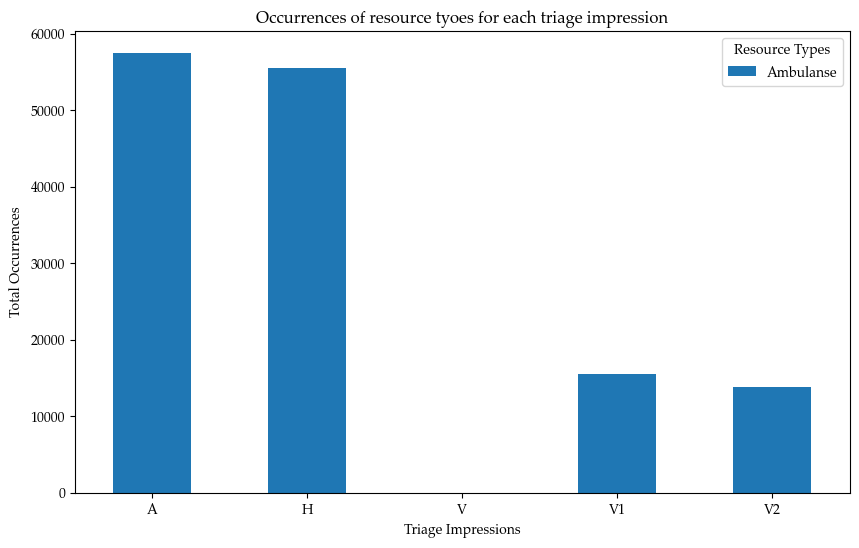

In [ ]:
df_testo = df_testo[df_testo["time_call_received"].dt.year == 2018]

plot_resources_per_triage(df_testo)


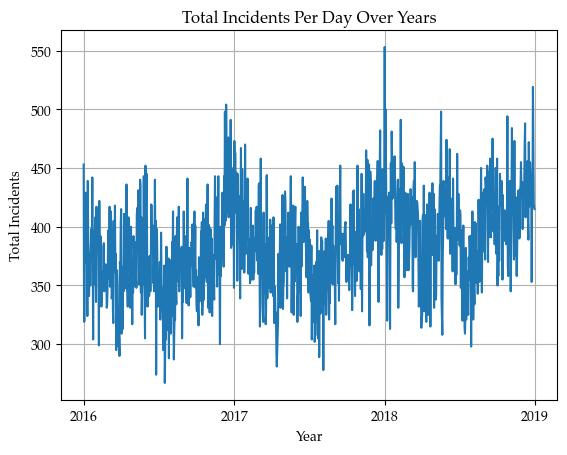

In [ ]:
plotter.incidents_over_years(dataframe)


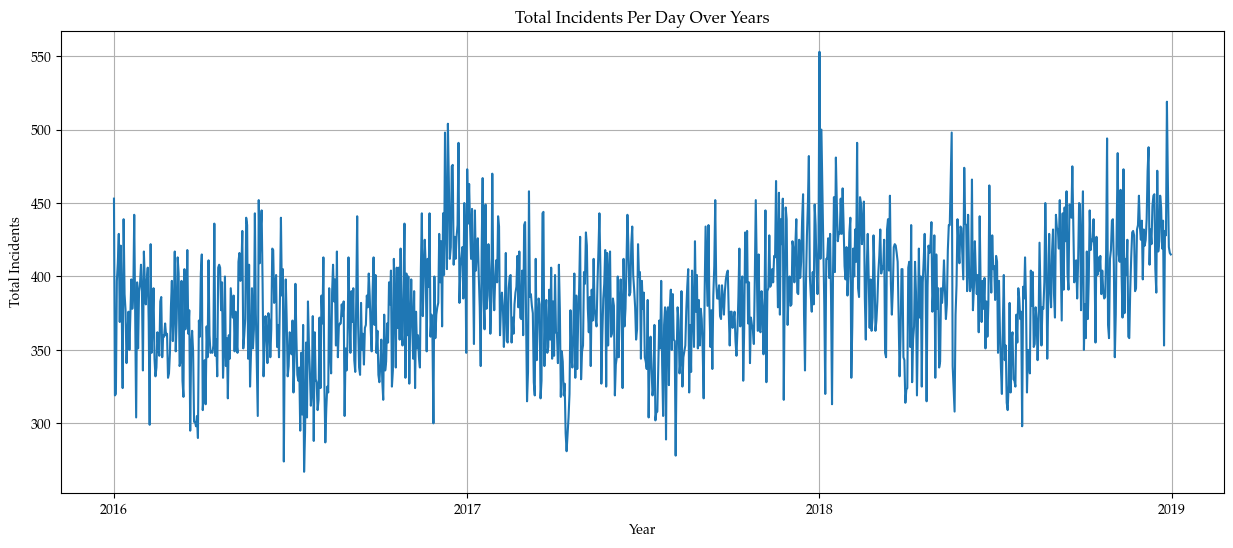

In [ ]:
plotter.incidents_over_years(dataframe, figsize=[15, 6])
